# Seqence
## 自回归模型 `autoregressive models`
预测时间序列数据

## 生成数据
使用正弦函数 $sin(x)$ 和可加性噪声 $\epsilon$

In [1]:
%matplotlib inline
import torch 
from torch import nn
from d2l import torch as d2l

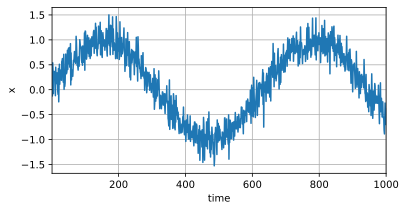

In [4]:
T = 1000 # 总共产生1000个点
time = torch.arange(1,T+1,dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0,0.2,(T,)) # 正弦值+噪声
d2l.plot(time,[x],"time","x",xlim=[1,1000],figsize=[6,3])

将序列 $[x]$ 转化为模型的 $feature-label$ ，特征维度是 $\tau$ ，映射规则如下：

$\bf y_t=x_t, x_t=[x_{t-\tau},...,x_{t-1}]$ 。

当然这会导致前面 $\tau$ 个数值会因为序列不够长被丢弃，解决方法如下：
- 零填充序列
- 若是序列足够长，丢弃也没关系1

这里取 $\tau=4$

In [7]:
tau = 4
features = torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i] = x[i:T-tau+i]
labels = x[tau:].reshape((-1,1)) # 前tau个样本被丢弃

这里取序列长度取为 $600$

In [9]:
batch_size,n_train = 16,600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train],labels[:n_train]),
                            batch_size,is_train=True)

- 网络架构：拥有 `2` 个全连接层的 `MLP`
- 激活函数：$ReLU$
- 损失函数：`MSE`

In [10]:
# 使用Xavier初始化网络权重
def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    
# MLP
def get_net():
    net = nn.Sequential(nn.Linear(4,10),
                       nn.ReLU(),
                       nn.Linear(10,1))
    net.apply(init_weights)
    return net

# MSE，计算时不带系数1/2
loss = nn.MSELoss(reduction='none')

# 训练模型

In [15]:
def train(net,train_iter,loss,epochs,lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f"epoch {epoch+1}, loss: {d2l.evaluate_loss(net,train_iter,loss):f}")
        
net = get_net()
train(net,train_iter,loss,5,0.01)

epoch 1, loss: 0.071877
epoch 2, loss: 0.055968
epoch 3, loss: 0.054448
epoch 4, loss: 0.059403
epoch 5, loss: 0.053105


# 预测模型
从上面可看出，训练损失较小，因此期待预测效果能够比较不错

首先检查单步预测的能力

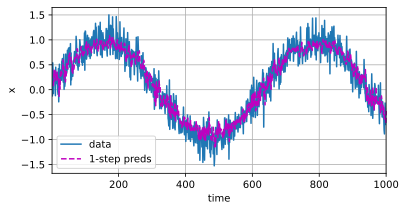

In [16]:
onestep_preds = net(features)
d2l.plot([time,time[tau:]],[x.detach().numpy(),onestep_preds.detach().numpy()],
        "time","x",legend=["data","1-step preds"],xlim=[1,1000],figsize=(6,3))

可以看到预测效果果然不错，即使在604步以后（训练数据只取了前600条），效果也依然不错。

然而还有一个小问题，因为之前的预测是单步预测，只能一步一步向前迈进，能不能有更快的预测方法？

**$k$ 步预测** ：对于直到 $x_t$ 的观测序列，在时间步 $t+k$ 出的预测输出 $\hat{x_{t+k}}$ 叫做 $k$ 步预测。$k=1$ 时即为单步预测，$k>1$ 时叫做多步预测

下面检查多步预测的效果，取 $k=4$

In [18]:
# 重新取 $feature-labels$
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train+tau,T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1,-1)))

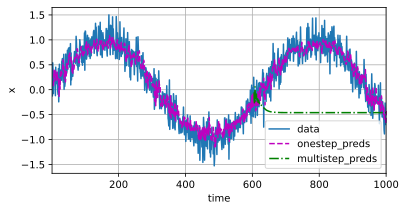

In [21]:
d2l.plot([time,time[tau:],time[n_train+tau:]],
        [x.detach(),onestep_preds.detach().numpy(),multistep_preds[n_train+tau:].detach().numpy()],
        "time","x",legend=["data","onestep_preds","multistep_preds"],
        xlim=[1,1000],figsize=(6,3))

可以看到 $4$ 步预测的结果不尽如人意，经过几轮衰减后，预测值降为一个常数。

出现这种情况的原因是：*错误累计* 。

假设第一步的错误是 $\epsilon_1$ ，第二步的输入会被扰动 $\epsilon_1$ ，得到的误差是 $\epsilon_2=\epsilon_2+c\epsilon_1$
误差会随着时间步不断累积，因此会相当快地偏离真实轨迹


取 $k=1,4,16,64$ .看多步预测的困难

In [23]:
max_steps =64

In [24]:
features = torch.zeros((T - tau - max_steps + 1,tau + max_steps))

# 来自x的观测，时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:,i] = x[i:i + T - tau - max_steps + 1]
    
# 来自（i-tau+1）的预测，时间步从（i）到（i+T-tau-max_stpes+1）
for i in range(tau,tau + max_steps):
    features[:,i] = net(features[:,i - tau:i]).reshape(-1)

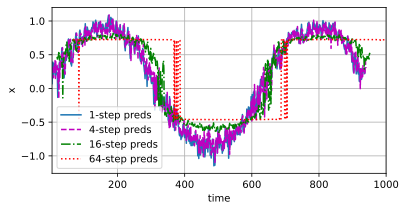

In [26]:
steps = (1,4,16,64)
d2l.plot([time[tau + i - 1:T - max_steps + i]  for i in steps],
        [features[:,tau + i - 1].detach().numpy() for i in steps],
        "time","x",legend=[f"{i}-step preds" for i in steps],xlim=[5,1000],
        figsize=(6,3))

可以看到，预测更远的未来时，预测质量急速下降